<a href="https://colab.research.google.com/github/fc510/merlin/blob/main/neural_network_from_scratch/nn_2_ex/nn_from_scratch_2_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network from Scratch

## A simple Neural Network

Implement a simple neural network (2x4x1) using python and numpy to emulate a XOR gate function.

| A | B | O |
|:--:|:--:|:--:|
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |



**Weigths, Bias & Activations**

```text
1 input layer:
    output size = 2
1 hidden layer;
    4 neurons
        1 neuron: 2 (input size) x 4 (neuron count) = 8 (weights count)
        4 neurons: 4 x 8 = 32 (weights total count)
1 output layer:
    1 output: 4 (input size) X 1 (neuron count) = 4 weights

```



## Implementation

In [1]:
import numpy as np
from pprint import pprint as pp
import matplotlib.pyplot as plt

In [3]:
class ActivationFunctions:
    """ ActivationFunctions """

    def __repr__(self):
        return_str = {"activation_name": self.activation_name}
        return f"{return_str}"

    def __str__(self):
        return self.__repr__()

    def __call__(self, activation_name='relu'):
        self.activation_name = activation_name

        if activation_name == 'relu':
            return (ActivationFunctions.relu, ActivationFunctions.relu_derivative)
        elif activation_name == 'tanh':
            return (ActivationFunctions.tanh, ActivationFunctions.tanh_derivative)
        elif activation_name == 'sigmoid':
            return (ActivationFunctions.sigmoid, ActivationFunctions.sigmoid_derivative)
        # elif activation_name == "cross_entropy_loss":
        #     return (ActivationFunctions.cross_entropy_loss, ActivationFunctions.cross_entropy_loss_derivative)
        else:
            raise ValueError("Unsupported activation function")

    def relu(x):
        return np.maximum(0, x)

    def relu_derivative(x):
        return np.where(x > 0, 1, 0)

    def tanh(x):
        return np.tanh(x)

    def tanh_derivative(x):
        return 1 - np.tanh(x) ** 2

    def leaky_relu(x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)

    def leaky_relu_derivative(x, alpha=0.01):
        return np.where(x > 0, 1, alpha)

    def sigmoid(x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def sigmoid_derivative(x):
        s = sigmoid(x)
        return s * (1 - s)


### Loss Function - Mean Squared Error

In [4]:
# Mean Squared Error loss and its derivative
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

# Cross Entropy Loss
def cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # Avoid log(0)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def cross_entropy_loss_derivative(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return (y_pred - y_true) / (y_pred * (1 - y_pred))


### Layer

In [5]:
class Layer:
    layer_index: int = 0

    def __repr__(self):
        index = self.layer_index
        activation_name = self.activation_name
        neuron_count = self.neuron_count
        json_string = str({
            "layer_index": index,
            "activation_name": activation_name,
            "neuron_count": neuron_count
            }
        )
        return f"{json_string}"

    def __str__(self):
        return self.__repr__()

    # def __init__(self, input_size, output_size, activation='relu'):
    def __init__(self, input_size, output_size, activation='relu', weights_init: np.ndarray = np.array([[1, 2, 3], [4, 5, 6]])):
        """
        input_size: Number of neurons in the previous layer
        output_size: Number of neurons in the current layer
        activation: Activation function to use for current layer
        """
        self.layer_index = Layer.layer_index
        Layer.layer_index += 1

        self.neuron_count = output_size
        self.biases = np.zeros((1, output_size))

        self.activation_name = activation
        self.activation = None
        self.activation_derivative = None
        self.weights = weights_init

        # set activation
        act = ActivationFunctions()
        self.activation, self.activation_derivative = act(activation_name=activation)

        # Store intermediate values for backpropagation
        self.input = None
        self.z = None  # Pre-activation values
        self.output = None

    def forward(self, x):
        # Compute weighted sum + bias
        self.input = x

        # print("\n\n" + f"({self.layer_index}) forward >>>")
        # print(f"(self.input)\n{x}.shape {x.shape}")
        # print(f"(self.weights)\n{self.weights}.shape {self.weights.shape}")
        # print(f"self.biases.shape [{self.biases.shape}]

        self.z = np.dot(x, self.weights) + self.biases
        # print(f"(self.z)\n{self.z}.shape {self.z.shape}")

        # Apply activation function
        self.output = self.activation(self.z)
        return self.output

    def backward(self, delta, learning_rate):
        # Compute gradient of activation
        delta = delta * self.activation_derivative(self.z)

        # Compute gradients for weights and biases
        d_weights = np.dot(self.input.T, delta)
        d_biases = np.sum(delta, axis=0, keepdims=True)

        # Compute delta for previous layer
        d_input = np.dot(delta, self.weights.T)

        # Update weights and biases
        self.weights -= learning_rate * d_weights
        self.biases -= learning_rate * d_biases
        return d_input

### Multi Layer Perceptron

In [6]:
class MLP:
    # def __init__(self, layer_sizes: list, activations: list):
    def __init__(self, layer_sizes: list, activations: list, weights_init: list):
        # Initialize layers
        self.layers = []
        self.activations = activations
        self.layer_sizes = layer_sizes

        for i in range(len(layer_sizes) - 1): # omit input layer
            # print("\n\n" + f"initializing layer [{i}]")
            # print(f"layer_sizes[{i}] [{layer_sizes[i]}]")
            # print(f"layer_sizes[{i + 1}] [{layer_sizes[i + 1]}]")

            self.layers.append(Layer(layer_sizes[i], layer_sizes[i + 1], activations[i], weights_init[i]))

    def info(self):
        """ model info """
        # info = {
        #     "layer_sizes": len(self.layers),
        #     "layers": self.layers,
        #     "activations": self.activations,
        # }
        print(f"layers count: [{len(self.layers)}]")
        for i in self.layers:
            print(i)

    @staticmethod
    def mk_weights(label='default', i_size=2, o_size=4):
        """
        Create np.array of initial weights base on
        - i_size x o_size shape
        - label
        """

        input_size = i_size
        output_size = o_size
        weights_init = []

        if label == 'default':
            # may be too small, which can lead to small gradients, especially with ReLU, causing slow learning or convergence to a poor solution
            return np.random.randn(input_size, output_size) * 0.01
        elif label == 'relu':
            # A larger initialization (He initialization)
            # He initialization for ReLU, standard normal for Tanh
            return np.random.randn(input_size, output_size) * np.sqrt(2 / input_size)
        elif label == 'tanh':
            return np.random.randn(input_size, output_size) * np.sqrt(1 / input_size)

    def forward(self, x):
        # Pass input through all layers
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, x, y, learning_rate):
        # Compute initial delta (gradient of loss w.r.t. output)
        output = self.forward(x)
        delta = mse_loss_derivative(y, output)

        # Backpropagate through layers in reverse
        for layer in reversed(self.layers):
            delta = layer.backward(delta, learning_rate)

    def fit(self, x, y, epochs, learning_rate):
        # Train the network
        loss_history = []

        for epoch in range(epochs):
            # print("\n\n" + f"EPOCH: [{epoch}] " + "#"*50)

            # Forward pass (thru all layers)
            output = self.forward(x)
            loss = cross_entropy_loss(y, output) if self.layers[-1].activation_name == 'sigmoid' else mse_loss(y, output)
            loss_history.append(loss)

            # # Compute and print loss every 1000 epochs
            # INTERVAL = 10
            # if epoch % INTERVAL == 0:
            #     loss = mse_loss(y, output)
            #     print(f"Epoch {epoch}, Loss: {loss:.4f}")

            # Backward pass (propagate back)
            self.backward(x, y, learning_rate)
        return loss_history

    def predict(self, x):
        # Return predicted output
        return self.forward(x)

    def evaluate(self, x, y, threshold=0.5):
        # Get predictions
        y_pred = self.predict(x)
        # Threshold predictions for binary classification
        y_pred_binary = (y_pred > threshold).astype(int)
        y_true_binary = y.astype(int)  # Ensure y is in 0/1 format

        # Compute accuracy
        accuracy = np.mean(y_pred_binary == y_true_binary)

        # Compute precision, recall, F1-score
        true_positives = np.sum((y_pred_binary == 1) & (y_true_binary == 1))
        predicted_positives = np.sum(y_pred_binary == 1)
        actual_positives = np.sum(y_true_binary == 1)

        precision = true_positives / predicted_positives if predicted_positives > 0 else 0
        recall = true_positives / actual_positives if actual_positives > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    def print_predictions(self, x, y, threshold=0.5):
        predictions = self.predict(x)
        print("\nPredictions:")
        for i, (pred, true) in enumerate(zip(predictions, y)):
            pred_binary = 1 if pred > threshold else 0
            print(f"Input: {x[i]}, Predicted: {pred[0]:.4f} ({pred_binary}), True: {true[0]}")

    def print_metrics(self, x, y):
        metrics = self.evaluate(x, y)
        print("Evaluation Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    def plot_decision_boundary(self, x, y):
        # Something I found during my search; probably good to include here.
        # >As noted:<br>
        # For the 2D XOR dataset, plotting the decision boundary to visually confirm if the model separates the classes correctly.
        x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
        y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
        grid = np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(grid)
        Z = (Z > 0.5).astype(int).reshape(xx.shape)

        plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
        plt.scatter(x[:, 0], x[:, 1], c=y.ravel(), cmap=plt.cm.RdBu, edgecolors='k')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Decision Boundary')
        plt.show()

### Dataset

In [7]:
# dataset (XOR-like binary classification)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])  # Inputs
y = np.array([[0], [1], [1], [0]])               # Targets

### Init Model

In [8]:
np.random.seed(42) # Ensures consistent initialization

# setup weights
weights_init = []
weights_init.append(MLP.mk_weights('relu', 2, 4))
weights_init.append(MLP.mk_weights('tanh', 4, 1))

# Initialize model: 2 input neurons, 4 hidden neurons (ReLU), 1 output neuron (Tanh)
model = MLP(layer_sizes=[2, 4, 1], activations=['relu', 'tanh'], weights_init=weights_init)

model.info()

layers count: [2]
{'layer_index': 0, 'activation_name': 'relu', 'neuron_count': 4}
{'layer_index': 1, 'activation_name': 'tanh', 'neuron_count': 1}


### Train the Model

In [9]:
# Train the model
EPOCHS = 50 # 10000
LEARNING_RATE = 0.1 # 0.1
loss_history = model.fit(X, y, epochs=EPOCHS, learning_rate=LEARNING_RATE)


### Analysze Loss over Time

In [10]:
def view_loss_history(loss_history, title='Training Loss Over Time'):
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

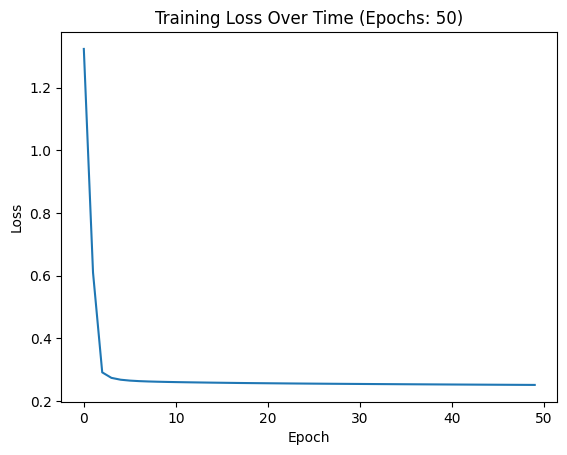

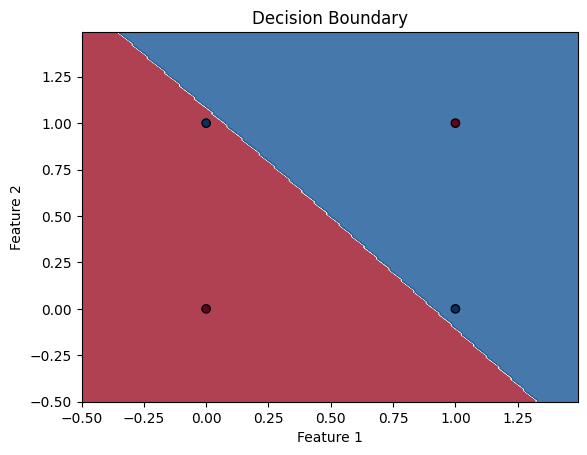

In [11]:
view_loss_history(loss_history, title='Training Loss Over Time'+f' (Epochs: {EPOCHS})')
model.plot_decision_boundary(X, y)

### Predict

In [12]:
model.print_predictions(X, y)


Predictions:
Input: [0 0], Predicted: 0.3920 (0), True: 0
Input: [0 1], Predicted: 0.4921 (0), True: 1
Input: [1 0], Predicted: 0.5095 (1), True: 1
Input: [1 1], Predicted: 0.5950 (1), True: 0


### Metrics

In [13]:
model.print_metrics(X, y)

Evaluation Metrics:
accuracy: 0.5000
precision: 0.5000
recall: 0.5000
f1_score: 0.5000


---
## Tune the Model

**Model Config**

- number of layers
- number of neurons
- weights initialization

**Hyperparameters**

- activation function
- epoch
- learning rate
- ...etc

### hyperparameter: EPOCH

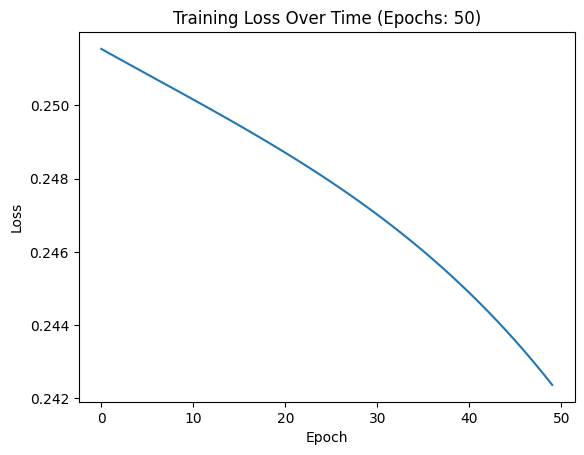

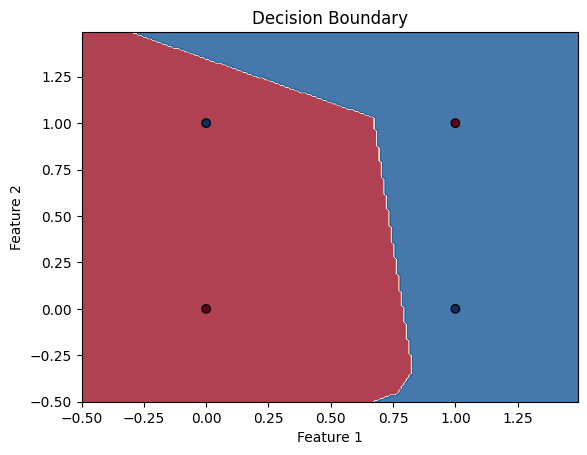

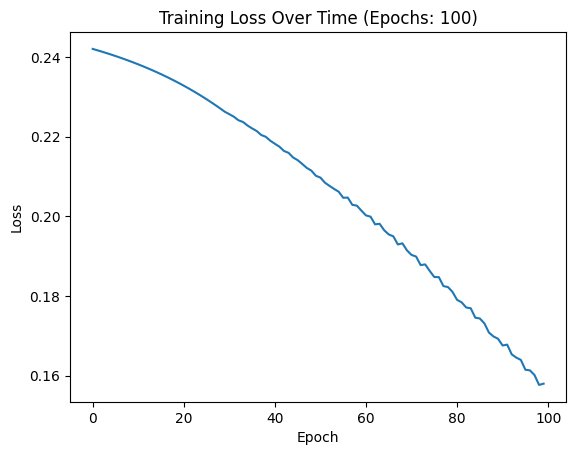

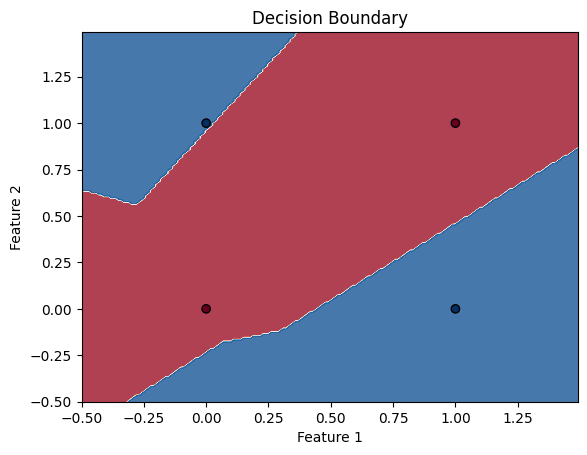

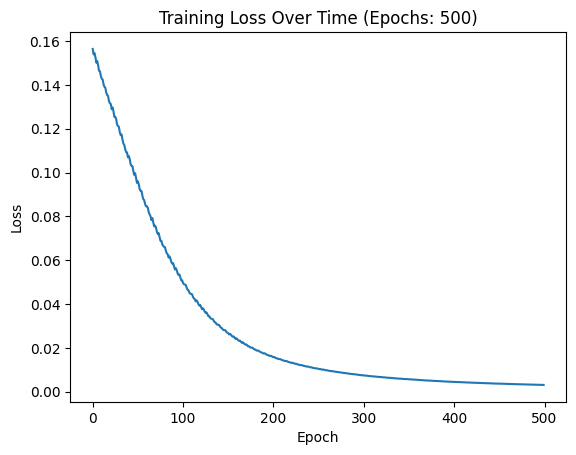

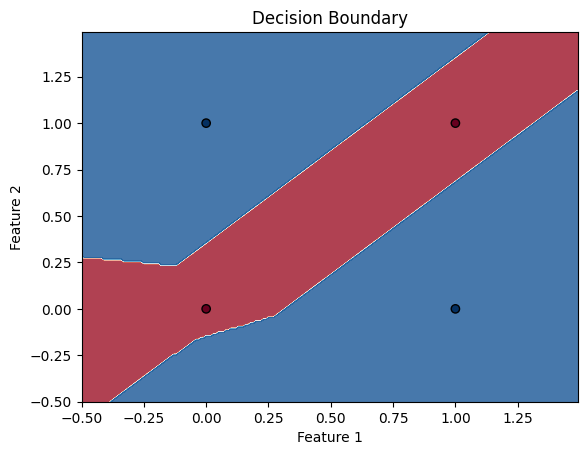

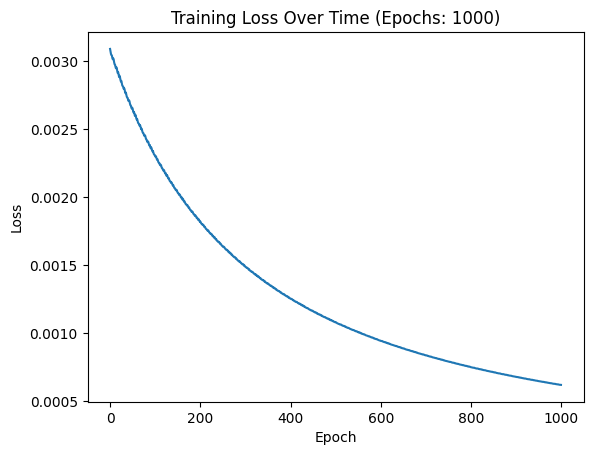

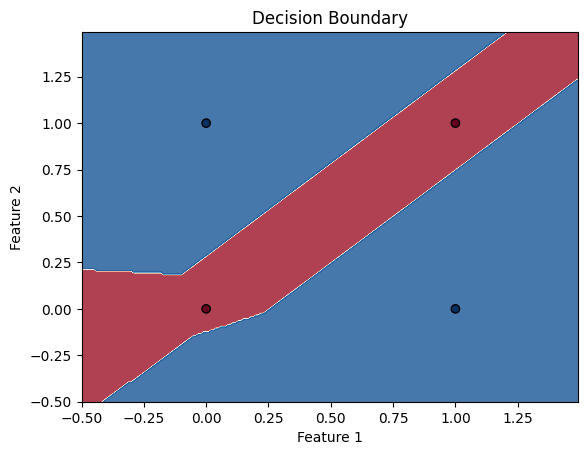

In [14]:
for epoch in [50, 100, 500, 1000]:
    loss_history = model.fit(X, y, epochs=epoch, learning_rate=LEARNING_RATE)
    view_loss_history(loss_history, title='Training Loss Over Time'+f' (Epochs: {epoch})')
    model.plot_decision_boundary(X, y)

### Summary

Small Dataset: The XOR dataset is tiny, perfect training performance is expected and typically generalizes. For larger datasets, adding a validation set is necessary to detect overfitting.

